# Training Supervised Machine Learning Models for Heart Disease Classification

<div>
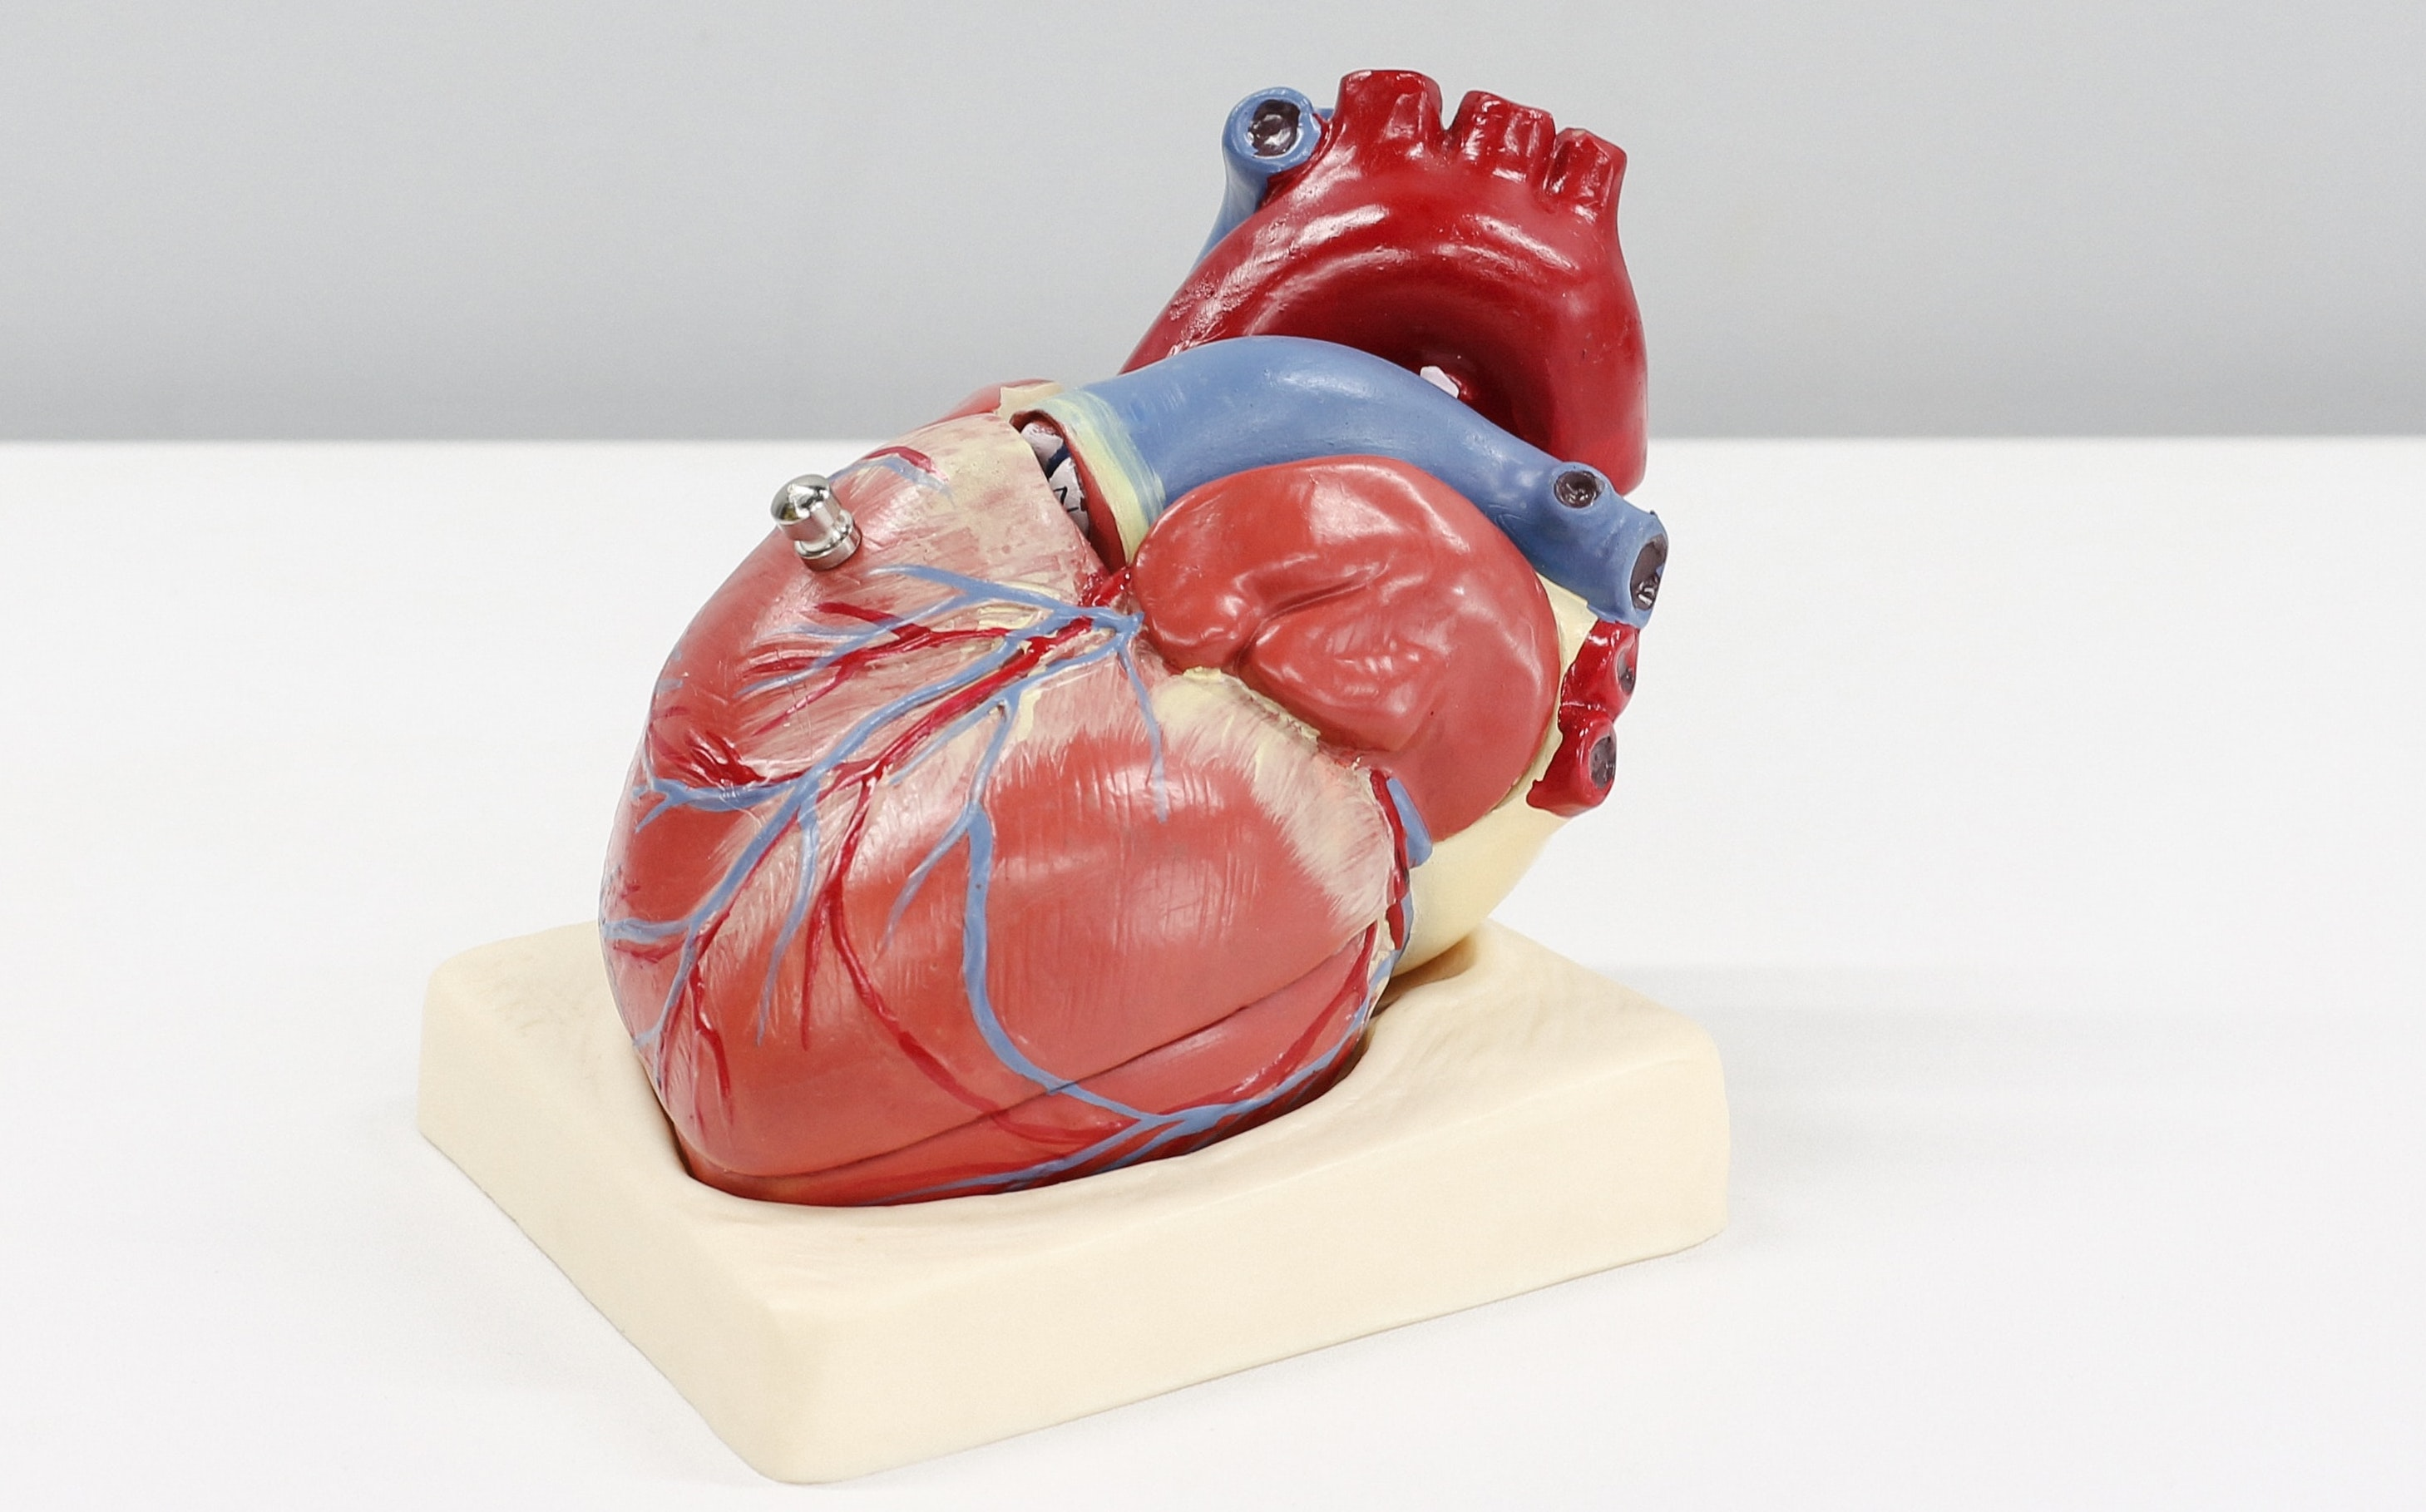
</div>

## Introduction

In this notebook I will be using the heart failure prediction dataset (https://www.kaggle.com/fedesoriano/heart-failure-prediction), to train and evaluate the performance of different machine learning classification models for the purpose of predicting if an observation has heart disease or not. This dataset consists of 5 combined datasets which are listed as follows:

- Cleveland: 303 observations
- Hungarian: 294 observations
- Switzerland: 123 observations
- Long Beach VA: 200 observations
- Stalog (Heart) Data Set: 270 observations

## Data preparation 

In this section we will check if there are any missing, NaN or duplicated values and drop these columns or replace the data accordingly.

In [1]:
import opendatasets as od

In [2]:
od.download("https://www.kaggle.com/fedesoriano/heart-failure-prediction")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: stakarz
Your Kaggle Key: ········


100%|██████████| 8.56k/8.56k [00:00<00:00, 2.09MB/s]

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np

In [5]:
df = pd.read_csv("heart-failure-prediction/heart.csv")

In [6]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [7]:
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [8]:
df.duplicated().value_counts()

False    918
dtype: int64

We are fortunate enough to have a clean dataset that doesn't contain any null values or duplicated data entries. Therefore, there is nothing to clean or replace. 

In [9]:
df.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

We can see that we have 5 categorical features and 6 numerical features.  

In [10]:
categorical = ["Sex", "ChestPainType", "RestingECG", "ExerciseAngina", "ST_Slope"]
numerical = ["Age", "RestingBP", "Cholesterol", "FastingBS", "MaxHR", "Oldpeak"] 

## Exploratory data analysis

In this section we will take a deeper dive into the data and explore specific features, their distributions and how they may contribute or impact the risk of heart disease.



In [11]:
df[categorical].nunique()

Sex               2
ChestPainType     4
RestingECG        3
ExerciseAngina    2
ST_Slope          3
dtype: int64

In [12]:
df.HeartDisease.value_counts(normalize=True)

1    0.553377
0    0.446623
Name: HeartDisease, dtype: float64

In [13]:
df.Sex.value_counts(normalize=True)

M    0.78976
F    0.21024
Name: Sex, dtype: float64

In [14]:
heart_disease = df[df["HeartDisease"] == 1]

In [15]:
heart_disease["Sex"].value_counts(normalize=True)

M    0.901575
F    0.098425
Name: Sex, dtype: float64

We can see that the dataset predominantly consists of male observations, the people who did suffer from heart disease were also found to be overwhelmingly male, accounting for over 90% of heart disease occurence. We can already start to consider how important the `Sex` feature might be.

<Figure size 1200x800 with 0 Axes>

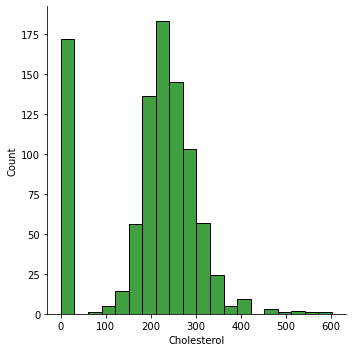

In [16]:
plt.figure(dpi=200);
sns.displot(df["Cholesterol"], bins=20, color="green");

The distribution of `Cholesterol` in the observations follows a normal distribution if we ignore the peak at 0, while it is possible for `Cholesterol` levels to be too low this is much less common than high cholesterol. It's likely that `Cholesterol` levels were not measured for these observations. We will leave this distribution as it is, as replacing the 0's with any other value will likely not be a sufficiently accurate indication of the observations true `Cholesterol` levels 

In [17]:
chest_pain_type = df["ChestPainType"].value_counts()

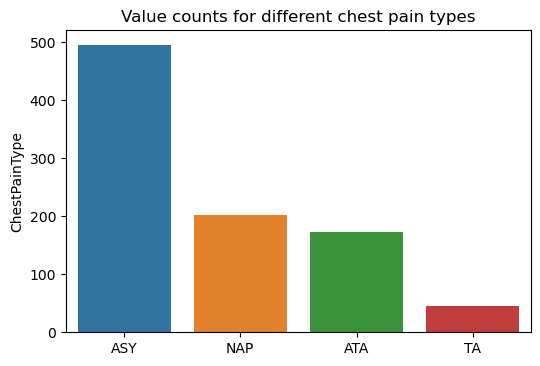

In [18]:
plt.figure(dpi=100)
plt.title("Value counts for different chest pain types")
sns.barplot(x=chest_pain_type.index, y=chest_pain_type);

<Figure size 900x600 with 0 Axes>

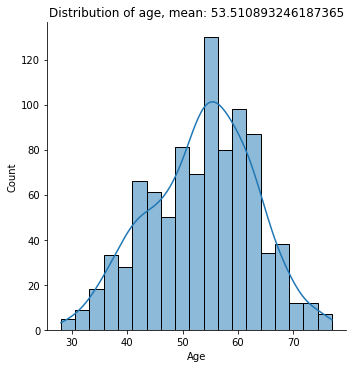

In [19]:
plt.figure(dpi=150);
sns.displot(df["Age"], kde=True).set(title=f"Distribution of age, mean: {df.Age.mean()}");

In [20]:
exercise_angina = df.ExerciseAngina.value_counts()

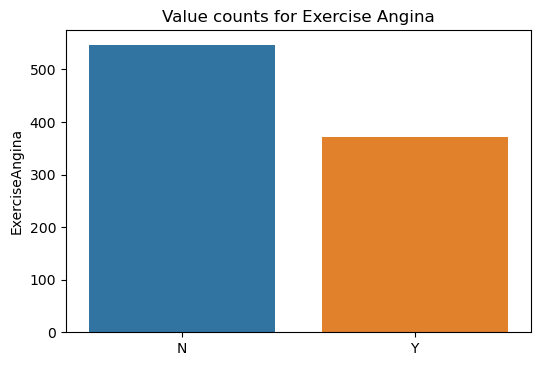

In [21]:
plt.figure(dpi=100)
sns.barplot(exercise_angina.index, exercise_angina).set(title="Value counts for Exercise Angina");

## Setting up the validation framework

In this section we will split the data into 3 sets, training data, validating data and test data. The split will be 60%, 20%, 20%, we will also separate the target variable `HeartDisease` from these datasets. The training dataset is what we will be using to fit the model, the model sees and learns from this data. The validation set is a sample for providing an unbiased evaluation of a model fit on the training set. The test dataset is utilised only when the model is fully trained, this sample is usually used to evaluate competing models. 

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [24]:
len(df_train), len(df_val), len(df_test)

(550, 184, 184)

In [25]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [26]:
y_train = df_train["HeartDisease"].values
y_val = df_val["HeartDisease"].values
y_test = df_test["HeartDisease"].values

del df_train["HeartDisease"]
del df_val["HeartDisease"]
del df_test["HeartDisease"]

## Feature importance: Risk ratio, Mutual information, Correlation

- figuring out which features affect our target variable
- fiding out how strongly the correlation is between the numerical features
- computing mutual information score for the categorical features

In [27]:
mean_heart_disease = df_full_train["HeartDisease"].mean()
mean_heart_disease

0.5422343324250681

### Risk Ratio - Gender

In [28]:
heart_disease_male = df_full_train[df_full_train.Sex == 'M'].HeartDisease.mean()

In [29]:
heart_disease_female = df_full_train[df_full_train.Sex == 'F'].HeartDisease.mean()

In [30]:
heart_disease_male / mean_heart_disease

1.1442481036029366

In [31]:
heart_disease_female / mean_heart_disease

0.4698652498159588

### Risk Ratio - Age

In [32]:
over_50 = df_full_train[df_full_train.Age > 50].HeartDisease.mean()

In [33]:
over_50 / mean_heart_disease

1.1440292750057341

In [34]:
over_60 = df_full_train[df_full_train.Age > 60].HeartDisease.mean()

In [35]:
over_60 / mean_heart_disease

1.3325297005257501

### Risk Ratio - Chest Pain Type

In [36]:
chest_pain_ASY = df_full_train[df_full_train.ChestPainType == 'ASY'].HeartDisease.mean()

In [37]:
chest_pain_ASY / mean_heart_disease

1.42763308930439

In [38]:
chest_pain_NAP = df_full_train[df_full_train.ChestPainType == 'NAP'].HeartDisease.mean()

In [39]:
chest_pain_NAP / mean_heart_disease

0.636695381670256

### Risk Ratio - Exercise Angina

In [40]:
exercise_angina = df_full_train[df_full_train.ExerciseAngina == 'Y'].HeartDisease.mean()

In [41]:
exercise_angina / mean_heart_disease

1.5453300987697105

### Mutual information

The mutual information score, a concept from information theory tells us how much which we can learn about one variable if we know the value of another. 

In [42]:
from sklearn.metrics import mutual_info_score

In [43]:
def calculate_mi(series):
    return mutual_info_score(series, df_full_train.HeartDisease)

In [44]:
mi = df_full_train[categorical].apply(calculate_mi)
mi.sort_values(ascending=False)

ST_Slope          0.184472
ChestPainType     0.151883
ExerciseAngina    0.123210
Sex               0.046335
RestingECG        0.006789
dtype: float64

### Correlation 

For numerical columns we can compute the pairwise correlation coefficients and visualise these values using a heatmap to get a rough idea of the relationships between numerical features.

In [45]:
df_numeric = df_full_train[numerical]
df_numeric.corr()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak
Age,1.000000,0.254344,-0.098738,0.170208,-0.370445,0.263697
RestingBP,0.254344,1.000000,0.089695,0.064129,-0.091828,0.168941
Cholesterol,-0.098738,0.089695,1.000000,-0.284800,0.282590,0.041161
FastingBS,0.170208,0.064129,-0.284800,1.000000,-0.112979,0.053265
MaxHR,-0.370445,-0.091828,0.282590,-0.112979,1.000000,-0.154316
Oldpeak,0.263697,0.168941,0.041161,0.053265,-0.154316,1.000000


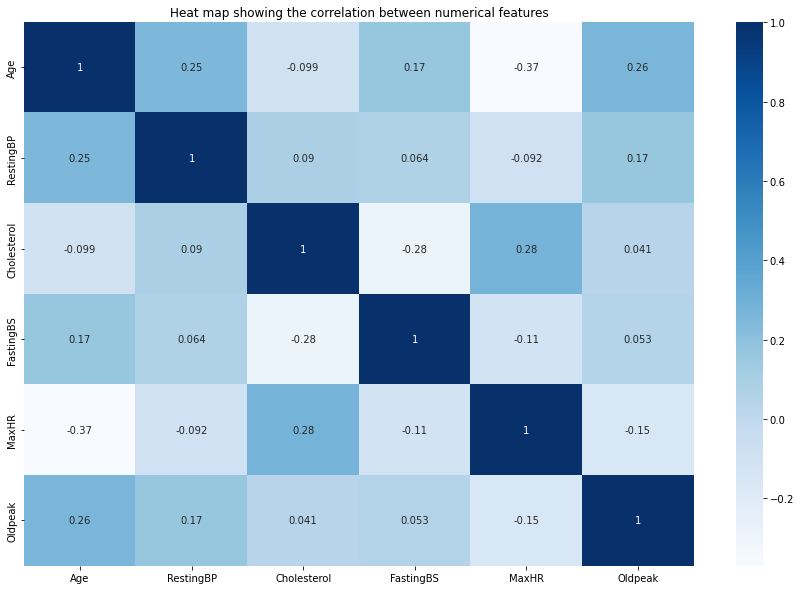

In [46]:
plt.figure(figsize=(15,10))
plt.title("Heat map showing the correlation between numerical features")
sns.heatmap(data=df_numeric.corr(), annot=True, cmap="Blues");

## One hot encoding 

Before we can begin training any models we will have to apply one hot encoding on our categorical variables, this is often necessary because many machine learning algorithms cannot operate on label data directly, they require all input and output variables to be numeric. One hot encoding works by assinging a binary value (1 or 0) for each unique variable, the variable will have a value of 1 it is present and 0 if it is absent.   

For example if we consider the categorical feature `ChestPainType` we can see that it has 4 different possible labels. For the 5th observation in the dataset the `ChestPainType` is equal to `ASY` therefore once we apply one hot encoding, the data will look like the constructed data frame `df`

In [47]:
df_full_train.ChestPainType.unique()

array(['ASY', 'NAP', 'TA', 'ATA'], dtype=object)

In [48]:
df_full_train.iloc[5]

Age                   46
Sex                    M
ChestPainType        ASY
RestingBP            120
Cholesterol          231
FastingBS              0
RestingECG        Normal
MaxHR                115
ExerciseAngina         Y
Oldpeak              0.0
ST_Slope            Flat
HeartDisease           1
Name: 262, dtype: object

In [49]:
data = {'ASY': [1],  "NAP": [0], "TA": [0], "ATA": [0]}

test_df = pd.DataFrame(data=data)
test_df

,ASY,NAP,TA,ATA
0,1,0,0,0


The `DictVectorizer` will transform lists of feature-value mappings to vectors, essentially this transformer turns lists of mappings (dict-like objects) of feature names to feature values into Numpy arrays. When feature values are strings (categorical variables), this transformer will do a binary one-hot (aka one-of-K) coding: one boolean-valued feature is constructed for each of the possible string values that the feature can take on.

In [50]:
from sklearn.feature_extraction import DictVectorizer 

In [51]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical+numerical].to_dict(orient="records")
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical+numerical].to_dict(orient="records")
X_val = dv.transform(val_dict)

## Training a Logistic Regression Model

Logistic regression is a supervised learning classification algorithm which we can use to predict the probability of a target variable in this case heart disease. The dependent variable is binary it's value can only be 1 or 0. 

In [52]:
from sklearn.linear_model import LogisticRegression

In [53]:
lr_model = LogisticRegression(solver="lbfgs", random_state=1)
lr_model.fit(X_train, y_train)

LogisticRegression(random_state=1)

After training the logistic regression model, we can use it to make probability estimates for each class (1 or 0). Our model outputs the probability of an observation suffering from heart disease based on the data supplied to it. However, we will need to transform these probabilities into classifications. One way of achieving this is to set a threshold, i.e. observations with a probability greater than or equal to this threshold will be classified as suffering from heart disease and observations below this threshold will be classified as not suffering from heart disease. 

In [54]:
y_pred = lr_model.predict_proba(X_val)[:,1]

In [55]:
y_pred[:10]

array([0.92259472, 0.95496225, 0.87878412, 0.5717942 , 0.89807921,
       0.88683787, 0.80545463, 0.65629323, 0.01652688, 0.89597521])

In [56]:
heart_disease_prediction = (y_pred >= 0.5)

We can set up a threshold for classifying if an observation should be labelled as 1 (heart disease) or 0 (no heart disease), we will start off with a value of 0.5. This means that from the predicted probabilities we will classify each observation as 1 (heart disease) if the probability is greater than or equal to 0.5. 

In [57]:
df_pred = pd.DataFrame()
df_pred["probability"] = y_pred
df_pred["actual"] = y_val
df_pred["prediction"] = heart_disease_prediction.astype(int)

In [58]:
df_pred["correct"] = df_pred["actual"] == df_pred["prediction"]

In [59]:
df_pred

,probability,actual,prediction,correct
0,0.922595,1,1,True
1,0.954962,0,1,False
2,0.878784,1,1,True
3,0.571794,1,1,True
4,0.898079,1,1,True
...,...,...,...,...
179,0.541061,0,1,False
180,0.988194,1,1,True
181,0.956117,1,1,True
182,0.274125,0,0,True


In [60]:
df_pred.correct.mean()

0.842391304347826

We can write this data to a dataframe and evaluate how well our model is performing, currently it is able to make predictions with above 84% accuracy, which is not bad for a basic logistic regression model with no additional parameters specified. 

In [61]:
from sklearn.metrics import accuracy_score

In [62]:
lr_model_accuracy = accuracy_score(y_val, y_pred>=0.5)

In [63]:
lr_model_accuracy

0.842391304347826

If we iterate through different thresholds at 0.05 intervals it turns out that the initial value we picked (0.5), performs very well in terms of accuracy score when compared to the best threshold value (0.55), which has a 1% higher accuracy score. 

In [64]:
thresholds = np.linspace(0,1,21)
scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred>=t)
    print(f"threshold: {round(t,2)}, accuracy_score: {round(score,3)}")
    scores.append(score)

threshold: 0.0, accuracy_score: 0.533
threshold: 0.05, accuracy_score: 0.663
threshold: 0.1, accuracy_score: 0.707
threshold: 0.15, accuracy_score: 0.723
threshold: 0.2, accuracy_score: 0.777
threshold: 0.25, accuracy_score: 0.81
threshold: 0.3, accuracy_score: 0.804
threshold: 0.35, accuracy_score: 0.837
threshold: 0.4, accuracy_score: 0.837
threshold: 0.45, accuracy_score: 0.832
threshold: 0.5, accuracy_score: 0.842
threshold: 0.55, accuracy_score: 0.853
threshold: 0.6, accuracy_score: 0.837
threshold: 0.65, accuracy_score: 0.837
threshold: 0.7, accuracy_score: 0.821
threshold: 0.75, accuracy_score: 0.799
threshold: 0.8, accuracy_score: 0.799
threshold: 0.85, accuracy_score: 0.772
threshold: 0.9, accuracy_score: 0.723
threshold: 0.95, accuracy_score: 0.625
threshold: 1.0, accuracy_score: 0.467


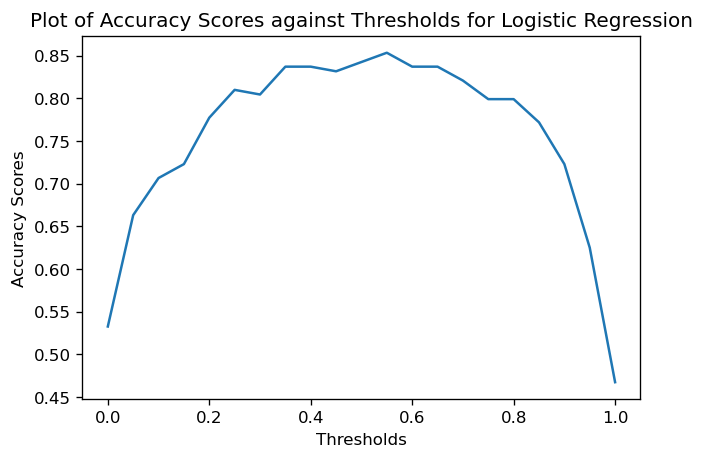

In [65]:
plt.figure(dpi=120)
plt.plot(thresholds, scores);
plt.title("Plot of Accuracy Scores against Thresholds for Logistic Regression");
plt.ylabel("Accuracy Scores");
plt.xlabel("Thresholds");

### Confusion Matrix

Accuracy scores may sometimes be misleading (especially if there is a class imbalance in the data) when trying to find the best threshold to use, a more reliable method is to compute the confusion matrix for different thresholds. A confusion matrix is a summary of prediction results on a classification problem, the number of correct and incorrect values are summarised. A confusion matrix consists of:
- **true negatives**: values the model predicted as 0 (no heart disease), and were actually 0
- **true positives** values the model predicted as 1 (heart disease) and and were actually 1
- **false negatives** values the model predicted as 0 but were actually 1
- **false positives** values the model predicted as 1 but were actually 0

In [66]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [67]:
t = 0.5
predicted_positive = (y_pred >= t)
predicted_negative = (y_pred < t)

In [68]:
tp = (actual_positive & predicted_positive).sum()
tn = (actual_negative & predicted_negative).sum()

fp = (predicted_positive & actual_negative).sum()
fn = (predicted_negative & actual_positive).sum()

In [69]:
confusion_matrix = np.array([
                        [tn, fp],
                        [fn,tp]
])

In [70]:
confusion_matrix

array([[73, 13],
       [16, 82]])

Ideally we would want to use a threshold that maximises tn & tp, and minimises fp & fn. One way of doing this would be generate a confusion matrix for each threshold at certain intervals but this would be very confusing and time consuming. Instead we can plot a ROC curve to obtain all the relevant information in one go. 

### ROC & AUC

ROC graphs provide a simple way to summarise the data that we are interested in a more concise way, in order to plot this graph we will need two further metrics, true positive rate (TPR) i.e. the true positives divided by the sum of true positives & false negatives and the false positive rate (FPR) which is the false positives divided by the sum of false positives & true negatives. 

- TPR = TP / TP + FN
- FPR = FP / FP + TN

The ideal point on the graph is where TPR is at it's maximum and FPR is at it's minimum.

In [71]:
scores = []
thresholds = np.linspace(0,1,101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predicted_positive = (y_pred >= t)
    predicted_negative = (y_pred < t)
    
    tp = (actual_positive & predicted_positive).sum()
    tn = (actual_negative & predicted_negative).sum()

    fp = (predicted_positive & actual_negative).sum()
    fn = (predicted_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [72]:
columns = ["threshold", "tp", "fp", "fn", "tn"]
df_scores = pd.DataFrame(columns=columns, data=scores)

In [73]:
df_scores["tpr"] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores["fpr"] = df_scores.fp / (df_scores.fp + df_scores.tn)

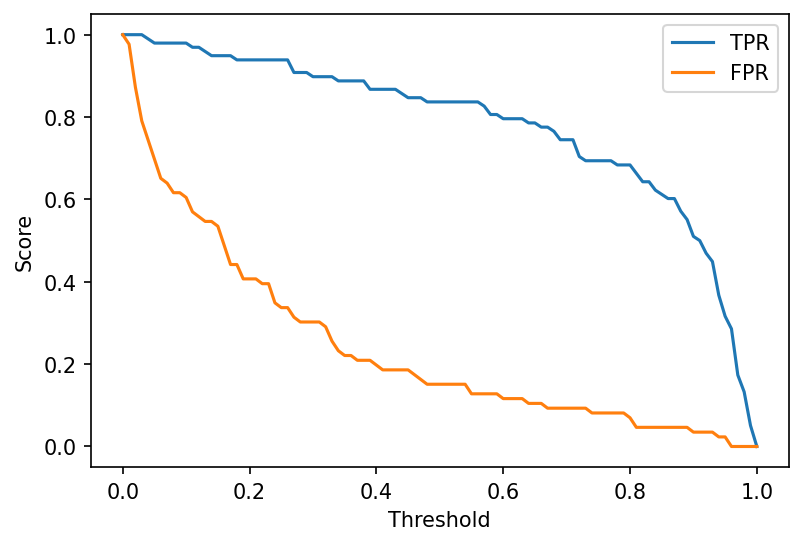

In [74]:
plt.figure(dpi=150)
plt.plot(df_scores.threshold, df_scores.tpr, label="TPR")
plt.plot(df_scores.threshold, df_scores.fpr, label="FPR")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend();

In [75]:
from sklearn.metrics import roc_curve

In [76]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

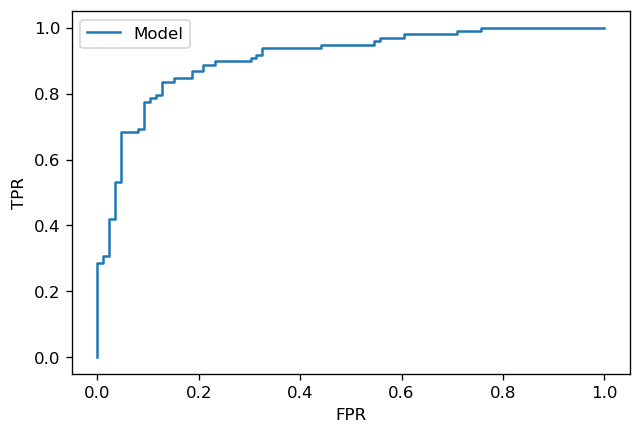

In [77]:
plt.figure(dpi=120)
plt.plot(fpr, tpr, label='Model')
plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend();

The AUC refers to the area under the curve and can be used to compare different models, the model with the ROC curve that has greater AUC generally indicates that it is the better model. The AUC for logistic regression is 0.90 which is already quite high. We will continue to use AUC as an evaluation metric to decide which model has the best performance for this classifcation problem.

In [78]:
from sklearn.metrics import roc_auc_score

In [79]:
lr_model_roc_auc = roc_auc_score(y_val, y_pred)

In [80]:
lr_model_roc_auc

0.9084005695301377

## Model Evaluation

Going forward we will evaluate the `accuracy_score` and `roc_auc_score` for each trained model using the validation set to find the one that performs best for this dataset. We will keep a track of these scores in a list which we will use to create a dataframe from in the end for model selection. We will use the same threshold of `t = 0.5` for each model as we found this value gives close to the best accuracy for classification.

In [81]:
metric_data = []
metric_data.append(("logistic_regression", lr_model_accuracy, lr_model_roc_auc))

## Training a Decision Tree Classifier Model

The goal of decision tree models is to predict the value of a target variable by learning simple decision rules inferred from the data features. The deeper the tree, the more complex the decision rules become. Essentially the data is continuously split according to a certain parameter. It's easier to define a decision tree in terms of two properties, decision nodes and leaves. The leaves are the final outcomes or decisions and the decision nodes are where the data is split. Decision trees can be useful as they are simple to understand, can be visualised and require little data preparation. On the other hand decision, tree learners can create overly complex-trees that are prone to overfitting i.e. trees that do not generalise well. 

In [82]:
from sklearn.tree import DecisionTreeClassifier

In [83]:
dt = DecisionTreeClassifier()

In [84]:
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [85]:
y_pred = dt.predict_proba(X_val)[:,1]

In [86]:
roc_auc_score(y_val, y_pred)

0.758424299952539

In [87]:
y_pred = dt.predict_proba(X_train)[:, 1]

In [88]:
roc_auc_score(y_train, y_pred)

1.0

The decision tree model with default parameters does not perform too bad with a ROC AUC score of 0.77, however if we evaluate the same model on the training data then we get an AUC score of 1.0. This indicates that the model has already overfit and does not generalise well. By tuning the parameters, we may be able to increase the AUC score and avoid overfitting. 

#### Tuning max_depth 

- This parameter is self explanatory and refers to the maximum depth of the tree, if not specified the nodes will be expanded until all the leaves are pure or until all the leaves contain less than `min_samples_split` samples

In [89]:
depths = [1, 2, 3, 4, 5, 6, 10, 15, 20, None]
for depth in depths:
    dt = DecisionTreeClassifier(max_depth=depth, random_state=1)
    dt.fit(X_train, y_train)
    y_pred = dt.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, y_pred)
    print(f"max_depth: {depth}, Score: {round(score,3)}")

max_depth: 1, Score: 0.742
max_depth: 2, Score: 0.831
max_depth: 3, Score: 0.863
max_depth: 4, Score: 0.854
max_depth: 5, Score: 0.874
max_depth: 6, Score: 0.847
max_depth: 10, Score: 0.771
max_depth: 15, Score: 0.774
max_depth: 20, Score: 0.774
max_depth: None, Score: 0.774


#### Tuning minimum samples leaf

- This parameter refers to the minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least `min_samples_leaf` training samples in each of the left and right branches. 

In [90]:
scores = []
for depth in [3, 4, 5]:
    for s in [1, 5 , 10, 15, 20, 50, 100, 200, 500]:
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=s, random_state=1)
        dt.fit(X_train, y_train)
        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append((depth, s, auc))
    

In [91]:
columns = ["max_depth", "min_samples_leaf", "auc"]
df_scores = pd.DataFrame(data=scores, columns=columns)

In [92]:
df_scores_pivot = df_scores.pivot(index="min_samples_leaf", columns=["max_depth"], values="auc")
df_scores_pivot.round(3)

max_depth,3,4,5
min_samples_leaf,,,
1,0.863,0.854,0.874
5,0.870,0.875,0.875
10,0.870,0.876,0.876
15,0.864,0.874,0.880
20,0.864,0.872,0.872
50,0.833,0.833,0.833
100,0.801,0.801,0.801
200,0.742,0.742,0.742
500,0.500,0.500,0.500


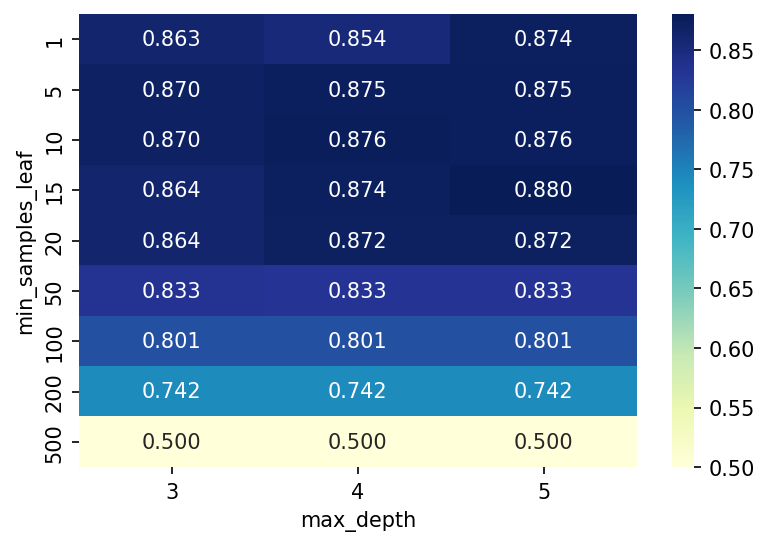

In [93]:
plt.figure(dpi=150)
sns.heatmap(df_scores_pivot, annot=True, cmap="YlGnBu", fmt=".3f");

The optimal parameters for the decision tree are `max_depth = 5` and `min_samples_leaf = 15`

In [94]:
dt_model = DecisionTreeClassifier(max_depth=5, min_samples_leaf=15, random_state=1)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=15, random_state=1)

In [95]:
y_pred = dt_model.predict_proba(X_val)[:,1]

In [96]:
decision_tree_roc_auc = roc_auc_score(y_val, y_pred)

In [97]:
decision_tree_roc_auc

0.880220692928334

In [98]:
decision_tree_accuracy = accuracy_score(y_val, y_pred>=0.55)

In [99]:
decision_tree_accuracy

0.7989130434782609

In [100]:
metric_data.append(("decision_tree", decision_tree_accuracy, decision_tree_roc_auc))

We can visualise what rules our decision tree is using by using `export_text`. For example the first decision node checks if the `ST_Slope=Up`  and if the condition is met the next condition `Cholesterol <= 42.50` is checked. However, if the first condition `ST_Slope=Up` is not met then we navigate to another decision node which checks if the condition `ChestPainType=ASY` is met. This process is repeated until the decision tree reaches a leaf (a decision)

In [101]:
from sklearn.tree import export_text
print(export_text(dt_model, feature_names=dv.get_feature_names()))

|--- ST_Slope=Up <= 0.50
|   |--- ChestPainType=ASY <= 0.50
|   |   |--- MaxHR <= 130.50
|   |   |   |--- ExerciseAngina=N <= 0.50
|   |   |   |   |--- class: 1
|   |   |   |--- ExerciseAngina=N >  0.50
|   |   |   |   |--- class: 1
|   |   |--- MaxHR >  130.50
|   |   |   |--- RestingBP <= 131.00
|   |   |   |   |--- class: 0
|   |   |   |--- RestingBP >  131.00
|   |   |   |   |--- class: 1
|   |--- ChestPainType=ASY >  0.50
|   |   |--- Sex=F <= 0.50
|   |   |   |--- MaxHR <= 139.00
|   |   |   |   |--- Cholesterol <= 199.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- Cholesterol >  199.50
|   |   |   |   |   |--- class: 1
|   |   |   |--- MaxHR >  139.00
|   |   |   |   |--- FastingBS <= 0.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- FastingBS >  0.50
|   |   |   |   |   |--- class: 1
|   |   |--- Sex=F >  0.50
|   |   |   |--- RestingBP <= 140.00
|   |   |   |   |--- class: 1
|   |   |   |--- RestingBP >  140.00
|   |   |   |   |--- class: 1
|--- ST_Slope=U

## Training a Random Forest Classifier

Similarly to decision tree's a random forest is a supervised machine learning algorithm, the "forest" that is built is an ensemble of decision trees. Essentially a random forest randomly selects which features/variables it is going to pull into a given tree, and then averages all of the decision trees to get our final model. Generally random forests perform with greater accuracy than decision trees however the model interpretability is not as straighforward for this type of model. 

#### Tuning `n_estimators`

- The first parameter we will tune for the random forest is the number of trees in the forest i.e. `n_estimators`

In [102]:
from sklearn.ensemble import RandomForestClassifier

In [103]:
scores = []
for n in range(10,201,10):

    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, y_pred)
    scores.append((n, auc))

In [104]:
columns = ["n_estimators", "auc"]
df_scores = pd.DataFrame(data=scores, columns=columns)

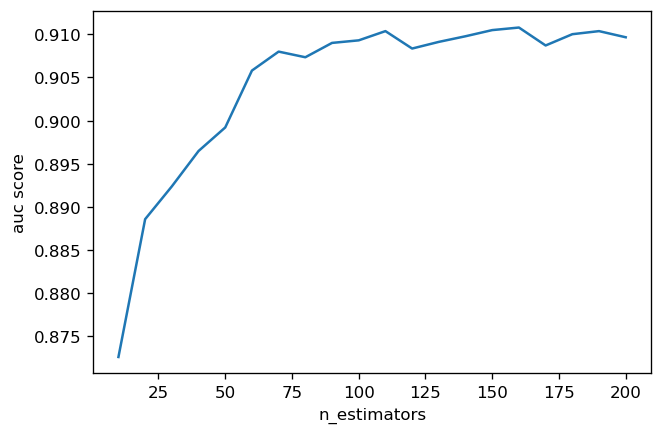

In [105]:
plt.figure(dpi=120)
plt.plot(df_scores.n_estimators, df_scores.auc)
plt.xlabel("n_estimators");
plt.ylabel("auc score");

The AUC score reaches a peak at approximately 100-110 `n_estimators` and proceeds to plateau. 

#### Tuning `max_depth`

- The maximum depth of the tree.

In [106]:
scores = []

for d in [5, 10, 15, 20]:
    for n in range(10,201,10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append((d, n, auc))

In [107]:
columns = ["max_depth", "n_estimators", "auc"]
df_scores = pd.DataFrame(data=scores, columns=columns)

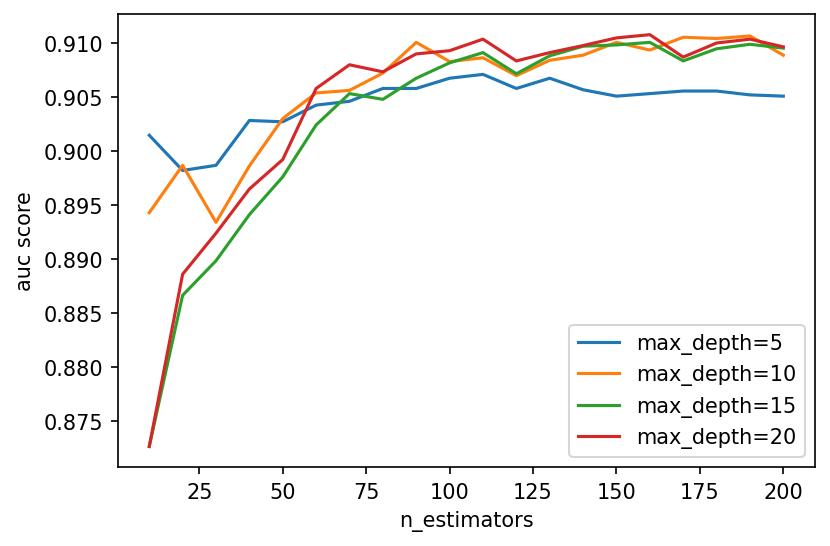

In [108]:
plt.figure(dpi=150)
for d in [5, 10, 15, 20]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.auc, label='max_depth=%d' %d)
    plt.xlabel("n_estimators")
    plt.ylabel("auc score")
    plt.legend()

The `max_depth` which gives the best `auc_score` is 10 which plateaus just before `n_estimators=100`

In [109]:
max_depth = 10

#### Tuning `min_samples_leaf`

- The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least `min_samples_leaf` training samples in each of the left and right branches

In [110]:
scores = []

for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((s, n, auc))

In [111]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

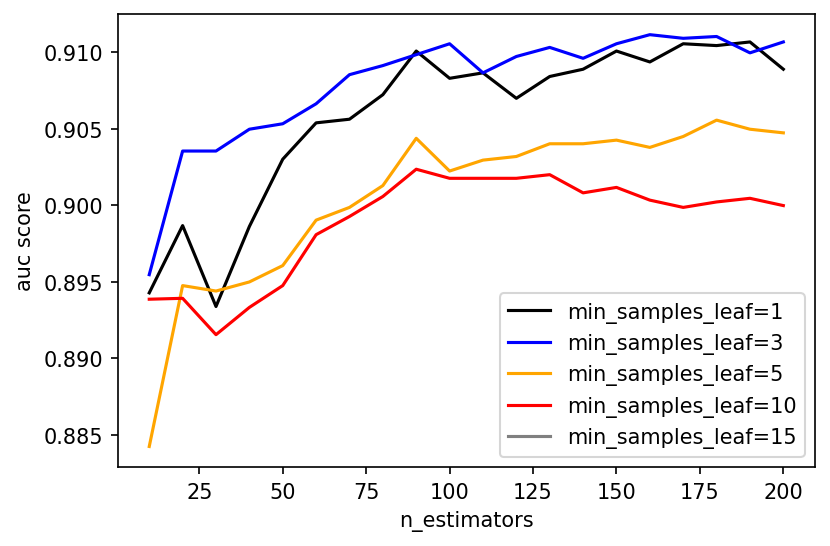

In [112]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
values = [1, 3, 5, 10, 15, 20, 50]

plt.figure(dpi=150)

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             color=col,
             label='min_samples_leaf=%d' % s)
    
    
plt.xlabel("n_estimators")
plt.ylabel("auc score")
plt.legend();

From the graph above the optimal value for the `min_samples_leaf` parameter is 3, now that we have all of our parameters we can tune the model and compute the AUC score for the random forest model.

In [113]:
min_samples_leaf = 3

In [114]:
rf_model = RandomForestClassifier(n_estimators=100,
                                    max_depth=max_depth,
                                    min_samples_leaf=min_samples_leaf,
                                    random_state=1)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict_proba(X_val)[:,1]

In [115]:
rf_roc_auc = roc_auc_score(y_val, y_pred)

In [116]:
rf_roc_auc

0.9105363075462743

In [117]:
rf_accuracy = accuracy_score(y_val, y_pred >= 0.5)

In [118]:
rf_accuracy

0.842391304347826

In [119]:
metric_data.append(("random_forest", rf_accuracy, rf_roc_auc))

We can find out the order of feature importances that the random forest model has decided on, this is quite a self explanatory measure. The higher the value the greater the features influence on the classification.

In [120]:
importances = rf.feature_importances_

In [121]:
df_importances = pd.DataFrame()
df_importances['feature'] = dv.get_feature_names()
df_importances['importance'] = rf.feature_importances_
df_importances.sort_values("importance", ascending=False)

,feature,importance
17,ST_Slope=Up,0.234044
16,ST_Slope=Flat,0.233908
1,ChestPainType=ASY,0.153136
6,ExerciseAngina=N,0.090487
10,Oldpeak,0.072018
7,ExerciseAngina=Y,0.050464
9,MaxHR,0.047417
2,ChestPainType=ATA,0.033927
5,Cholesterol,0.029499
0,Age,0.028682


## XGBoost

XGBoost stands for e**X**treme **G**radient **B**oosting, it is a gradient boosting library designed to be efficeint, portable and flexible. It implements machine learning algorithms under gradient boosting framework. Boosting is an ensemble machine learning technique to build a strong classifier from several weak classifiers in seies. Gradient boosting's main goal is to minimize the loss function by adding weak learners using a gradient descent optimization algorithm. 


In [122]:
import xgboost as xgb

In [123]:
features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [124]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=10)

[16:53:55] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [125]:
y_pred = model.predict(dval)

In [126]:
roc_auc_score(y_val, y_pred)

0.8824157570004746

With default parameters we managed to train a XGBoost model with a ROC AUC score of 0.88, let's see if what score we achieve when tuning the parameters `eta`, `max_depth` and `min_child_weight`.

In [127]:
watchlist = [(dtrain, "train"), (dval, "val")]

### Early stopping 

We can utilise early stopping to find the optimal number of boosting rounds. Providing the validation data as a parameter in `evals` will cause the model to train until the validation auc score stops improving. 

In [128]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [129]:
s = output.stdout

In [130]:
print(s[:200])

[0]	train-auc:0.95524	val-auc:0.87304
[5]	train-auc:0.99113	val-auc:0.87791
[10]	train-auc:0.99763	val-auc:0.88236
[15]	train-auc:0.99937	val-auc:0.87826
[20]	train-auc:0.99988	val-auc:0.87803
[25]	tr


### Tuning `eta`


In [131]:
for n in [0.01, 0.02, 0.05, 0.1, 0.15, 0.2, 0.3]:
    xgb_params = {
    'eta': n, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}
    model = xgb.train(xgb_params, dtrain, num_boost_round=200, verbose_eval=5)
    y_pred = model.predict(dval)
    auc = roc_auc_score(y_val, y_pred)
    print(f"eta: {n}, auc_score: {round(auc,3)}")
    

eta: 0.01, auc_score: 0.892
eta: 0.02, auc_score: 0.897
eta: 0.05, auc_score: 0.89
eta: 0.1, auc_score: 0.891
eta: 0.15, auc_score: 0.889
eta: 0.2, auc_score: 0.888
eta: 0.3, auc_score: 0.875


In [132]:
for n1 in [0.01,0.02, 0.05, 0.1]:
    for n2 in [1, 2, 3, 4, 5, 6, 10, 15, 20]:
        xgb_params = {
            'eta': n1, 
            'max_depth': n2,
            'min_child_weight': 1,

            'objective': 'binary:logistic',
            'eval_metric': 'auc',

            'nthread': 8,
            'seed': 1,
            'verbosity': 1,
        }
        model = xgb.train(xgb_params, dtrain, num_boost_round=200, verbose_eval=5)
        y_pred = model.predict(dval)
        auc = roc_auc_score(y_val, y_pred)
        print(f"eta: {n1}, max_depth: {n2} auc_score: {round(auc,3)}")

eta: 0.01, max_depth: 1 auc_score: 0.857
eta: 0.01, max_depth: 2 auc_score: 0.888
eta: 0.01, max_depth: 3 auc_score: 0.892
eta: 0.01, max_depth: 4 auc_score: 0.894
eta: 0.01, max_depth: 5 auc_score: 0.894
eta: 0.01, max_depth: 6 auc_score: 0.892
eta: 0.01, max_depth: 10 auc_score: 0.893
eta: 0.01, max_depth: 15 auc_score: 0.893
eta: 0.01, max_depth: 20 auc_score: 0.893
eta: 0.02, max_depth: 1 auc_score: 0.883
eta: 0.02, max_depth: 2 auc_score: 0.901
eta: 0.02, max_depth: 3 auc_score: 0.905
eta: 0.02, max_depth: 4 auc_score: 0.904
eta: 0.02, max_depth: 5 auc_score: 0.891
eta: 0.02, max_depth: 6 auc_score: 0.897
eta: 0.02, max_depth: 10 auc_score: 0.897
eta: 0.02, max_depth: 15 auc_score: 0.898
eta: 0.02, max_depth: 20 auc_score: 0.898
eta: 0.05, max_depth: 1 auc_score: 0.903
eta: 0.05, max_depth: 2 auc_score: 0.905
eta: 0.05, max_depth: 3 auc_score: 0.898
eta: 0.05, max_depth: 4 auc_score: 0.895
eta: 0.05, max_depth: 5 auc_score: 0.891
eta: 0.05, max_depth: 6 auc_score: 0.89
eta: 0.05, 

In [133]:
eta = 0.02
max_depth = 3

In [134]:

for n in range(1,6):
    xgb_params = {
        'eta': eta, 
        'max_depth': max_depth,
        'min_child_weight': n,

        'objective': 'binary:logistic',
        'eval_metric': 'auc',

        'nthread': 8,
        'seed': 1,
        'verbosity': 1,
    }
    model = xgb.train(xgb_params, dtrain, num_boost_round=200, verbose_eval=5)
    y_pred = model.predict(dval)
    auc = roc_auc_score(y_val, y_pred)
    print(f"min_child_weight: {n} auc_score: {round(auc,3)}")

min_child_weight: 1 auc_score: 0.905
min_child_weight: 2 auc_score: 0.904
min_child_weight: 3 auc_score: 0.903
min_child_weight: 4 auc_score: 0.901
min_child_weight: 5 auc_score: 0.899


In [135]:
min_child_weight = 1

In [136]:
xgb_params = {
            'eta': eta, 
            'max_depth': max_depth,
            'min_child_weight': min_child_weight,

            'objective': 'binary:logistic',
            'eval_metric': 'auc',

            'nthread': 8,
            'seed': 1,
            'verbosity': 1,
        }
xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=200, verbose_eval=5)
y_pred = xgb_model.predict(dval)
xgb_auc = roc_auc_score(y_val, y_pred)
print(xgb_auc)

0.9053156146179402


In [137]:
xgb_accuracy = accuracy_score(y_val, y_pred>=0.5)
xgb_accuracy

0.8478260869565217

In [138]:
metric_data.append(("xgb_boost", xgb_accuracy, xgb_auc))

In [139]:
metric_data

[('logistic_regression', 0.842391304347826, 0.9084005695301377),
 ('decision_tree', 0.7989130434782609, 0.880220692928334),
 ('random_forest', 0.842391304347826, 0.9105363075462743),
 ('xgb_boost', 0.8478260869565217, 0.9053156146179402)]

In [140]:
columns = ["model", "accuracy_score", "roc_auc_score"]
df_metrics = pd.DataFrame(columns=columns, data=metric_data)

In [141]:
df_metrics

,model,accuracy_score,roc_auc_score
0,logistic_regression,0.842391,0.908401
1,decision_tree,0.798913,0.880221
2,random_forest,0.842391,0.910536
3,xgb_boost,0.847826,0.905316


From our `df_metrics` data frame its clear that the two best models are the `random_forest` and `xgb_boost`, we will now compare well how these two models perform on unseen data.

## K-Fold Cross Validation

K-Fold cross validation is a statistical method used to estimate how well a model can perform on unseen data, it can also be utilised for model comparison and selection. This cross validation technique works by randomly shuffling the data and splitting it into K groups. At each iteration one group of data is considered the test set, while the remaning groups are combined together to make the training set. The model is tested on the test group and the process resumes for K groups. By the end you will have K different results on K different test groups, the best model can be selected by choosing the one with the highest average evaluation metric score. 

## Data preparation 

We will use a 80%/20% train/test split and use K = 5 for the number of splits.

In [142]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

In [143]:
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [144]:
y_train = df_train["HeartDisease"].values
y_test = df_test["HeartDisease"].values

del df_train["HeartDisease"]
del df_test["HeartDisease"]

In [145]:
test_dict = df_test[categorical+numerical].to_dict(orient="records")
X_test = dv.transform(test_dict)

### Evaluation

For our final model comparison and selection we cross validate and compute both `accuracy_score` and `roc_auc_score` to help us make a decision on which model is more suitable for this dataset.

In [146]:
scoring = ["accuracy", "roc_auc"]

In [147]:
def train(df_train, y_train):
    
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = RandomForestClassifier(n_estimators=100,
                                    max_depth=max_depth,
                                    min_samples_leaf=min_samples_leaf,
                                    random_state=1)
    model.fit(X_train, y_train)
    
    return dv, model

In [148]:
dv, model = train(df_train, y_train)

In [149]:
def predict(df, dv, model):
    
    dicts = df[categorical + numerical].to_dict(orient='records')
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred


In [150]:
y_pred = predict(df_test, dv, model)

In [151]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True, random_state=1)
roc_auc_scores = []
accuracy_scores = []

for train_idx, test_idx in kfold.split(df):
        df_train = df.iloc[train_idx]
        df_test = df.iloc[test_idx]

        y_train = df_train.HeartDisease.values
        y_test = df_test.HeartDisease.values

        dv, model = train(df_train, y_train)
        y_pred = predict(df_test, dv, model)

        auc = roc_auc_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred>=0.5)
        
        roc_auc_scores.append(auc)
        accuracy_scores.append(accuracy)

    
roc_auc_scores = np.array(roc_auc_scores)
accuracy_scores = np.array(accuracy_scores)



In [152]:
print(f"Average ROC AUC score for random forest classifier is {roc_auc_scores.mean()}\nAverage accuracy score for random forest classifier is {accuracy_scores.mean()}")

Average ROC AUC score for random forest classifier is 0.9252189717960299
Average accuracy score for random forest classifier is 0.867064623425992


In [153]:
xgb_params = {
            'eta': eta, 
            'max_depth': max_depth,
            'min_child_weight': min_child_weight,

            'objective': 'binary:logistic',
            'eval_metric': 'auc',

            'nthread': 8,
            'seed': 1,
            'verbosity': 1,
        }

In [154]:
def train(df_train, y_train):
    
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    xgb.train(xgb_params, dtrain, num_boost_round=200, verbose_eval=5)
    
    return dv, model

In [155]:
dv, model = train(df_train, y_train)

In [156]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True, random_state=1)
roc_auc_scores = []
accuracy_scores = []

for train_idx, test_idx in kfold.split(df):
        df_train = df.iloc[train_idx]
        df_test = df.iloc[test_idx]

        y_train = df_train.HeartDisease.values
        y_test = df_test.HeartDisease.values

        dv, model = train(df_train, y_train)
        y_pred = predict(df_test, dv, model)

        auc = roc_auc_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred>=0.5)
        
        roc_auc_scores.append(auc)
        accuracy_scores.append(accuracy)

    
roc_auc_scores = np.array(roc_auc_scores)
accuracy_scores = np.array(accuracy_scores)

In [157]:
print(f"Average ROC AUC score for XGBoost is {roc_auc_scores.mean()}\nAverage accuracy score for XGBoost is {accuracy_scores.mean()}")

Average ROC AUC score for XGBoost is 0.934149038245042
Average accuracy score for XGBoost is 0.864896650035638


## Conclusion

After K-Fold cross validating both models and making predictions using unseen data namely the test data set, we can confirm that the XGBoost is superior to all the remaining classification models. The random forest classifier comes very close and fares only less than 1% worse in terms of `roc_auc_score`. Therefore, we can now train the tuned XGBoost model on the full data set and use it to make predictions on unseen data.